Sources:

1. https://www.kaggle.com/code/ciobeni/fake-news-prediction (for preprocessing, countvectorizer and evaluation code)
2. https://excellencetechnologies.in/blog/bag-of-words-count-vectorizer/
3. https://www.analyticsvidhya.com/blog/2021/08/a-friendly-guide-to-nlp-bag-of-words-with-python-example/
4. https://www.tensorflow.org/tutorials/text/word2vec
5. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
6. https://stackoverflow.com/questions/47711515/apply-countvectorizer-to-column-with-list-of-words-in-rows-in-python

# Importing relevant libraries

In [1]:
import nltk # Used for preprocessing
import string # Used for preprocessing
import numpy as np # Used for saving
import pandas as pd # Used for dataframe
import matplotlib.pyplot as plt # For plotting the graphs
import seaborn as sns # For the confusion matrix

from nltk.corpus import stopwords # Used for preprocessing
from nltk.stem   import WordNetLemmatizer # Used for preprocessing
from nltk.tokenize import word_tokenize # Used for preprocessing
from sklearn.model_selection import train_test_split # Used for splitting the data

from sklearn.model_selection import GridSearchCV # Used for tuning
from sklearn.metrics import confusion_matrix # Used for confusion matrix
from sklearn.feature_extraction.text import CountVectorizer # Used for CountVectorizer feature extraction 
from sklearn.svm import SVC # Used for SVM modeling
from sklearn.model_selection import cross_validate # Used for cross-validation
from sklearn.metrics import classification_report # Used for model evaluation

import joblib # For saving the model

# Loading the data

In [2]:
# Loading the dataset

df = pd.read_csv('WELFake_Dataset.csv', index_col = 0)
df = df.dropna()

# Preprocessing the data

In [3]:
# Preprocessing

def preprocess_text(text):
    text = ''.join([c for c in text if c not in string.punctuation and c not in string.digits])
    tokens = word_tokenize(text, 'english')
    lowered = [x.lower() for x in tokens] # new
    lemmatiser = WordNetLemmatizer()
    lemmatized = [lemmatiser.lemmatize(word) for word in lowered] # Adjusted
    sw = stopwords.words('english')
    stopped = [word for word in lemmatized if word.lower() not in sw]
    return stopped

In [4]:
# Splitting the data

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [5]:
# Create a list of preprocessed articles

prep_X_train = []
for article_train in X_train[:]:
    prep_X_train.append(preprocess_text(article_train))

prep_X_test = []
for article_test in X_test[:]:
    prep_X_test.append(preprocess_text(article_test))

X_train = prep_X_train
X_test = prep_X_test

# Feature Extraction: CountVectorizer

In [6]:
#X_train = X_train.fillna('')
vectorizer = CountVectorizer(analyzer=lambda x: x)
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x7f959ad801f0>)

In [7]:
print("Vocabulary size:", len(vectorizer.get_feature_names_out()))

Vocabulary size: 304405


In [8]:
# Initializing and saving CountVectorizer matrix

matrix = vectorizer.transform(X_train) # Matrix is the CBOW feature extraction for X train

In [9]:
frequencies = sum(matrix).toarray()[0]
ngrams = pd.DataFrame(frequencies, index = vectorizer.get_feature_names_out(), columns = ['frequency'])
ngrams = ngrams.sort_values(by='frequency', ascending = False)
ngrams.iloc[:50]

,frequency
’,296899
“,211201
”,209632
wa,196210
said,185210
trump,165861
ha,141004
state,88670
u,85901
would,84263


# Scoring the model: SVM

In [10]:
svm = SVC()
scores = cross_validate(svm, matrix, y_train, scoring=['f1', 'accuracy'], cv=5, n_jobs=-1) # Scoring the training

In [11]:
pd.DataFrame(scores).describe()

,fit_time,score_time,test_f1,test_accuracy
count,5.000000,5.000000,5.000000,5.000000
mean,4315.533477,422.659062,0.961543,0.960230
std,735.192772,107.302197,0.002242,0.002365
min,3251.246527,274.785286,0.959013,0.957627
25%,4290.084508,341.213334,0.959393,0.957889
50%,4333.868780,496.932272,0.962100,0.960772
75%,4374.582201,497.116317,0.963240,0.962167
max,5327.885368,503.248102,0.963969,0.962694


# Tuning

Source:

1. https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/ # For the hyperparameter code
2. https://dataaspirant.com/svm-kernels/#t-1608054630726 # For different kernel options
3. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html # For possible hyperparameters

In [13]:
# defining parameter range
param_grid = {'kernel': ['rbf'],
              'C': [0.001, 0.01, 0.1, 1], 
              'gamma': [1, 10, 50, 100]} 
  
grid = GridSearchCV(svm, param_grid, refit = True, cv = 2, verbose = 3)
  
# fitting the model for grid search
grid.fit(matrix, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END ......C=0.001, gamma=1, kernel=rbf;, score=0.511 total time=61.9min
[CV 2/2] END ......C=0.001, gamma=1, kernel=rbf;, score=0.511 total time=65.1min
[CV 1/2] END .....C=0.001, gamma=10, kernel=rbf;, score=0.511 total time=55.7min
[CV 2/2] END ....C=0.001, gamma=10, kernel=rbf;, score=0.511 total time=120.3min
[CV 1/2] END .....C=0.001, gamma=50, kernel=rbf;, score=0.511 total time=52.3min
[CV 2/2] END .....C=0.001, gamma=50, kernel=rbf;, score=0.511 total time=53.9min
[CV 1/2] END ....C=0.001, gamma=100, kernel=rbf;, score=0.511 total time=52.0min
[CV 2/2] END ....C=0.001, gamma=100, kernel=rbf;, score=0.511 total time=60.3min
[CV 1/2] END .......C=0.01, gamma=1, kernel=rbf;, score=0.511 total time=47.6min
[CV 2/2] END .......C=0.01, gamma=1, kernel=rbf;, score=0.511 total time=47.2min
[CV 1/2] END ......C=0.01, gamma=10, kernel=rbf;, score=0.511 total time=47.3min
[CV 2/2] END ......C=0.01, gamma=10, kernel=rbf;

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'gamma': [1, 10, 50, 100],
                         'kernel': ['rbf']},
             verbose=3)

In [14]:
# print best parameter after tuning
print(grid.best_params_)
print("\n")

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


SVC(C=1, gamma=1)


In [15]:
# defining parameter range
param_grid = {'kernel': ['rbf'],
              'C': [1, 10], 
              'gamma': ['scale']} 
  
grid = GridSearchCV(svm, param_grid, refit = True, cv = 2, verbose = 3)
  
# fitting the model for grid search
grid.fit(matrix, y_train)

# print best parameter after tuning
print(grid.best_params_)
print("\n")

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2] END ......C=1, gamma=scale, kernel=rbf;, score=0.952 total time=25.3min
[CV 2/2] END ......C=1, gamma=scale, kernel=rbf;, score=0.956 total time=25.5min
[CV 1/2] END .....C=10, gamma=scale, kernel=rbf;, score=0.961 total time=32.5min
[CV 2/2] END .....C=10, gamma=scale, kernel=rbf;, score=0.962 total time=32.7min
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


SVC(C=10)


In [ ]:
# vanaf hier verder

## Training the model

In [16]:
# Train the model using the whole training set
svm = SVC(C = 10, gamma = 'scale', kernel = 'rbf') # Initializing the model
svm.fit(matrix, y_train) # Training the model with the Y train data and X feature extraction data

SVC(C=10)

# Using test data

In [17]:
test_matrix = vectorizer.transform(X_test)
y_pred = svm.predict(test_matrix)

In [18]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.979212,0.961098,0.969807,0.970155,0.969992
recall,0.958861,0.980365,0.969807,0.969613,0.969807
f1-score,0.968930,0.970636,0.969807,0.969783,0.969798
support,7025.000000,7283.000000,0.969807,14308.000000,14308.000000


Text(51.0, 0.5, 'Real Labels')

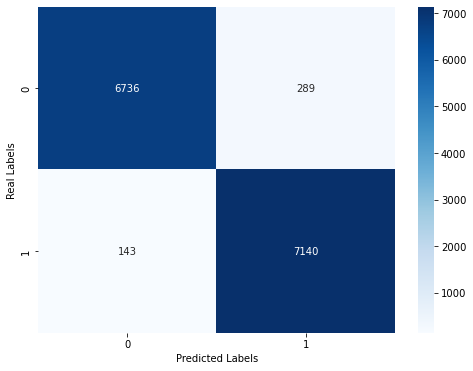

In [19]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [20]:
joblib.dump(svm,'/Users/pietervanbrakel/Thesis/SVM_text_2.pkl',compress=3)

['/Users/pietervanbrakel/Thesis/SVM_text_2.pkl']

In [21]:
svm = joblib.load('/Users/pietervanbrakel/Thesis/SVM_text_2.pkl')

# Split confusion matrix

In [22]:
df = pd.read_csv('WELFake_Dataset.csv', index_col = 0)

In [23]:
df_kaggle = df.loc[:20799]
df_McIntire = df.loc[20800:27134]
df_Reuters = df.loc[27135:72032]
df_Buzzfeed = df.loc[72033:]

df_kaggle = df_kaggle.dropna()
df_McIntire = df_McIntire.dropna()
df_Reuters = df_Reuters.dropna()
df_Buzzfeed = df_Buzzfeed.dropna()

In [24]:
print("Nr. of news articles in Kaggle :", len(df_kaggle))
print("Nr. of news articles in McIntire :", len(df_McIntire))
print("Nr. of news articles in Reuters :", len(df_Reuters))
print("Nr. of news articles in Buzzfeed :", len(df_Buzzfeed))

Nr. of news articles in Kaggle : 20664
Nr. of news articles in McIntire : 6285
Nr. of news articles in Reuters : 44487
Nr. of news articles in Buzzfeed : 101


In [25]:
df_kaggle_y = df_kaggle.iloc[:, 2]
df_kaggle_x = df_kaggle.iloc[:, 1]
df_McIntire_y = df_McIntire.iloc[:, 2]
df_McIntire_x = df_McIntire.iloc[:, 1]
df_Reuters_y = df_Reuters.iloc[:, 2]
df_Reuters_x = df_Reuters.iloc[:, 1]
df_Buzzfeed_y = df_Buzzfeed.iloc[:, 2]
df_Buzzfeed_x = df_Buzzfeed.iloc[:, 1]

### Kaggle sub-dataset

In [26]:
# Create a list of preprocessed articles
kaggle_X = []
for article_train in df_kaggle_x[:]:
    kaggle_X.append(preprocess_text(article_train))

df_kaggle_x = kaggle_X

In [27]:
# Create y_pred_Kaggle
kaggle_test_matrix = vectorizer.transform(df_kaggle_x)
kaggle_y_pred = svm.predict(kaggle_test_matrix)

In [42]:
pd.DataFrame(classification_report(df_kaggle_y, kaggle_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.995346,0.985900,0.990418,0.990623,0.990467
recall,0.984785,0.995690,0.990418,0.990238,0.990418
f1-score,0.990037,0.990771,0.990418,0.990404,0.990416
support,9990.000000,10674.000000,0.990418,20664.000000,20664.000000


Text(51.0, 0.5, 'Real Labels')

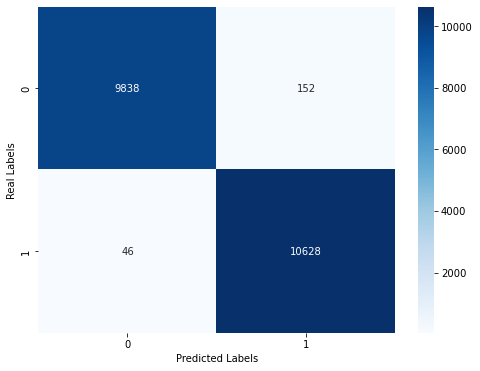

In [29]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_kaggle_y, kaggle_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

### McIntire

In [30]:
# Create a list of preprocessed articles
McIntire_X = []
for article_train in df_McIntire_x[:]:
    McIntire_X.append(preprocess_text(article_train))

df_McIntire_x = McIntire_X

In [31]:
# Create y_pred_McIntire
McIntire_test_matrix = vectorizer.transform(df_McIntire_x)
McIntire_y_pred = svm.predict(McIntire_test_matrix)

In [32]:
pd.DataFrame(classification_report(df_McIntire_y, McIntire_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.994071,0.987689,0.990772,0.990880,0.990794
recall,0.986920,0.994422,0.990772,0.990671,0.990772
f1-score,0.990482,0.991044,0.990772,0.990763,0.990771
support,3058.000000,3227.000000,0.990772,6285.000000,6285.000000


Text(51.0, 0.5, 'Real Labels')

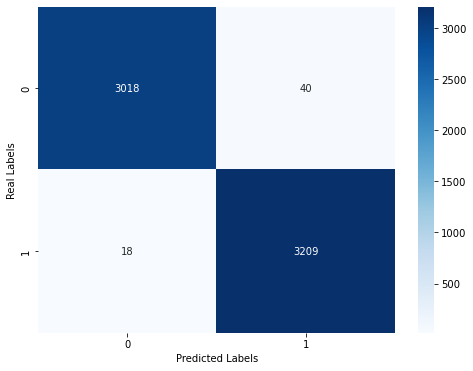

In [33]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_McIntire_y, McIntire_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

### Reuters

In [34]:
# Create a list of preprocessed articles
Reuters_X = []
for article_train in df_Reuters_x[:]:
    Reuters_X.append(preprocess_text(article_train))

df_Reuters_x = Reuters_X

In [35]:
# Create y_pred_Reuters
Reuters_test_matrix = vectorizer.transform(df_Reuters_x)
Reuters_y_pred = svm.predict(Reuters_test_matrix)

In [36]:
pd.DataFrame(classification_report(df_Reuters_y, Reuters_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.995344,0.984995,0.990042,0.990170,0.990098
recall,0.984408,0.995521,0.990042,0.989965,0.990042
f1-score,0.989846,0.990230,0.990042,0.990038,0.990041
support,21935.000000,22552.000000,0.990042,44487.000000,44487.000000


Text(51.0, 0.5, 'Real Labels')

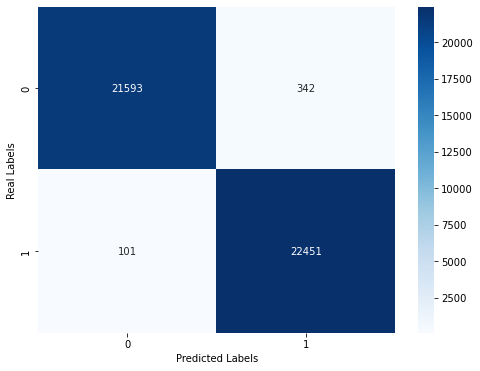

In [37]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_Reuters_y, Reuters_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

### Buzzfeed

In [38]:
# Create a list of preprocessed articles
Buzzfeed_X = []
for article_train in df_Buzzfeed_x[:]:
    Buzzfeed_X.append(preprocess_text(article_train))

df_Buzzfeed_x = Buzzfeed_X

In [39]:
# Create y_pred_Reuters
Buzzfeed_test_matrix = vectorizer.transform(df_Buzzfeed_x)
Buzzfeed_y_pred = svm.predict(Buzzfeed_test_matrix)

In [40]:
pd.DataFrame(classification_report(df_Buzzfeed_y, Buzzfeed_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.982456,0.990099,0.991228,0.990273
recall,0.977778,1.000000,0.990099,0.988889,0.990099
f1-score,0.988764,0.991150,0.990099,0.989957,0.990087
support,45.000000,56.000000,0.990099,101.000000,101.000000


Text(51.0, 0.5, 'Real Labels')

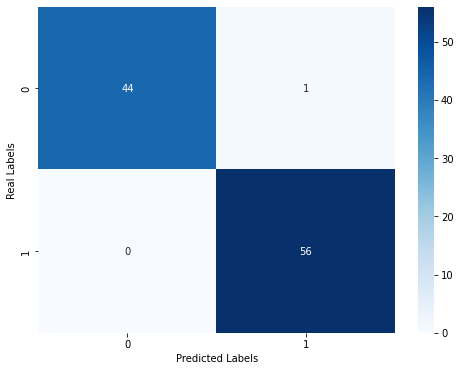

In [41]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_Buzzfeed_y, Buzzfeed_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')